In [1]:
%matplotlib inline

In [2]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()

sdss = full_sdss[behroozi_complete & good_profile_mask]
print("Number of M*-complete SDSS galaxies with good profile measurements = {0}".format(len(sdss)))
print(sdss.keys())

Number of M*-complete SDSS galaxies with good profile measurements = 229889
['ra', 'dec', 'z', 'bptclass', 'sm', 'sfr', 'specsfr', 'sm_fib', 'sfr_fib', 'specsfr_fib', 'withinr', 'eligiblehost', 'sm_complete', 'eligiblehost2', 'd4000', 'd4000_sub', 'd4000_n', 'd4000_n_sub', 'has_match', 'logM_mendel13', 'logMB_mendel13', 'logMD_mendel13', 'pps_mendel13', 'type_mendel13', 'deltaBD_mendel13', 'dr7_objID', 'has_meert15_match', 'r50_magr_kpc_meert15', 'Magr_tot_meert15', 'Magr_bulge_meert15', 'Magr_disk_meert15', 'gr_bulge_meert15', 'gr_disk_meert15', 'morph_type_T_meert15', 'gr_kcorr_meert15', 'bulge_to_total_rband_meert15', 'logsm_bell03_meert15', 'ssfr']


In [3]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
print(halocat.halo_table.keys())

from halotools.empirical_models import Moster13SmHm
model = Moster13SmHm()

['halo_vmax_firstacc', 'halo_dmvir_dt_tdyn', 'halo_macc', 'halo_scale_factor', 'halo_vmax_mpeak', 'halo_m_pe_behroozi', 'halo_delta_vmax_behroozi17', 'halo_xoff', 'halo_spin', 'halo_tidal_force', 'halo_scale_factor_firstacc', 'halo_c_to_a', 'halo_mvir_firstacc', 'halo_scale_factor_last_mm', 'halo_tidal_id', 'halo_scale_factor_mpeak', 'halo_pid', 'halo_m500c', 'halo_id', 'halo_halfmass_scale_factor', 'halo_upid', 'halo_t_by_u', 'halo_rvir', 'halo_vpeak', 'halo_dmvir_dt_100myr', 'halo_mpeak', 'halo_m_pe_diemer', 'halo_jx', 'halo_jy', 'halo_jz', 'halo_m2500c', 'halo_mvir', 'halo_voff', 'halo_axisA_z', 'halo_axisA_x', 'halo_axisA_y', 'halo_y', 'halo_b_to_a', 'halo_x', 'halo_z', 'halo_m200b', 'halo_vacc', 'halo_scale_factor_lastacc', 'halo_vmax', 'halo_m200c', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_dmvir_dt_inst', 'halo_tidal_force_tdyn', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo']


In [193]:
zpeak = 1./halocat.halo_table['halo_scale_factor_mpeak'] - 1.

mstar_unity_h = model.mc_stellar_mass(prim_haloprop=halocat.halo_table['halo_mpeak'],
                                     redshift=zpeak)
mstar_mpeak = mstar_unity_h/halocat.cosmology.h/halocat.cosmology.h

from astropy.table import Table

mock = Table()

keys_from_halo_catalog = ('halo_upid', 'halo_mpeak', 'halo_scale_factor_mpeak', 
                         'halo_x', 'halo_y', 'halo_z', 
                         'halo_vx', 'halo_vy', 'halo_vz', 
                          'halo_mvir_host_halo', 'halo_spin')

mstar_mask = mstar_mpeak > 10**9
for key in keys_from_halo_catalog:
    mock[key[5:]] = halocat.halo_table[key][mstar_mask]
mock['zpeak'] = zpeak[mstar_mask]

cenmask = mock['scale_factor_mpeak'] > 1
mock['zpeak0'] = mock['zpeak']
mock['zpeak0'][cenmask] = 0.
mock['scale_factor_mpeak0'] = mock['scale_factor_mpeak']
mock['scale_factor_mpeak0'][cenmask] = 1.

mock['mstar_mpeak'] = mstar_mpeak[mstar_mask]
print(mock.keys())

['upid', 'mpeak', 'scale_factor_mpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'mvir_host_halo', 'spin', 'zpeak', 'zpeak0', 'scale_factor_mpeak0', 'mstar_mpeak']


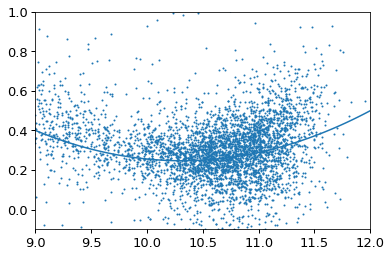

In [194]:
fig, ax = plt.subplots(1, 1)

__=ax.scatter(sdss['sm'][::50], sdss['logsm_bell03_meert15'][::50]-sdss['sm'][::50], s=1)

xlim=ax.set_xlim(9, 12)
ylim = ax.set_ylim(-.1, 1)


from halotools.empirical_models import solve_for_polynomial_coefficients

abscissa = 9, 10.5, 12
ordinates = 0.4, 0.25, 0.5
a0, a1, a2 = solve_for_polynomial_coefficients(abscissa, ordinates)

x = np.linspace(9, 12, 100)
__=ax.plot(x, a0 + a1*x + a2*x*x)


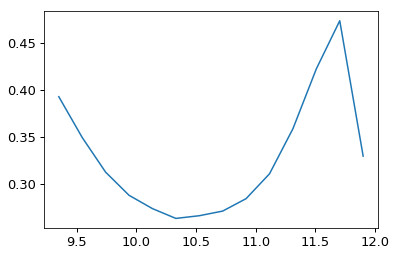

In [195]:
logsm_mpajhu_bins = np.linspace(9.25, 12, 15)
logsm_mpajhu_table = 0.5*(logsm_mpajhu_bins[:-1] + logsm_mpajhu_bins[1:])

from scipy.stats import binned_statistic

logsm_diff = sdss['logsm_bell03_meert15'] - sdss['sm']
logsm_correction_table, __, __ = binned_statistic(sdss['sm'], logsm_diff, bins=logsm_mpajhu_bins, 
                                           statistic='median')

fig, ax = plt.subplots(1, 1)

__=ax.plot(logsm_mpajhu_table, logsm_correction_table)

In [196]:
logsm_correction = np.interp(np.log10(mock['mstar_mpeak']), 
                             logsm_mpajhu_table, logsm_correction_table)

logsm_mock = np.log10(mock['mstar_mpeak'])
logsm_polynomial_correction = a0 + a1*logsm_mock + a2*logsm_mock**2

mock['mstar_mpeak_corrected'] = 10**(np.log10(mock['mstar_mpeak']) + logsm_polynomial_correction)

In [197]:
from halotools.empirical_models import halo_mass_to_halo_radius

rvir_peak_comoving_unity_h = halo_mass_to_halo_radius(mock['mpeak'], 
                                halocat.cosmology, mock['zpeak'], 'vir')
rvir_peak_physical = rvir_peak_comoving_unity_h*mock['scale_factor_mpeak']/halocat.cosmology.h
mock['rvir_halo_zpeak'] = rvir_peak_physical*1000.

In [198]:
rvir_peak_comoving_unity_h = halo_mass_to_halo_radius(mock['mpeak'], 
                                halocat.cosmology, mock['zpeak0'], 'vir')
rvir_peak_physical = rvir_peak_comoving_unity_h*mock['scale_factor_mpeak0']/halocat.cosmology.h
mock['rvir_halo_zpeak0'] = rvir_peak_physical*1000.

In [199]:
from galsize_models.models import component_size_vs_rhalo

rvir = mock['rvir_halo_zpeak']
normalization_all = 0.0125
alpha_all = 1.
scatter_all = 0.2
size_seed=14041

mock['r50'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all, seed=size_seed)

from scipy.stats import binned_statistic
logsm_bins = np.linspace(9, 12, 25)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

median_rhalf_all_mock, __, __ = binned_statistic(
        np.log10(mock['mstar_mpeak']), mock['r50'], bins=logsm_bins)
median_rhalf_all_mock_corrected, __, __ = binned_statistic(
        np.log10(mock['mstar_mpeak_corrected']), mock['r50'], bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar_mpeak']), 
                              logsm_mids, median_rhalf_all_mock_corrected)


In [200]:
rvir = mock['rvir_halo_zpeak']
normalization_all = 0.0125
alpha_all = 1.
scatter_all = 0.25
size_seed=14041

mock['r50_zpeak0'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all, seed=size_seed)

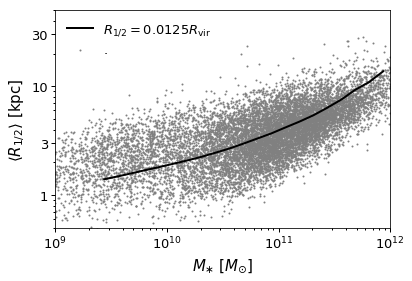

In [201]:
from matplotlib import ticker 

fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.scatter(10**sdss['logsm_bell03_meert15'][::20], 
              sdss['r50_magr_kpc_meert15'][::20], 
             s=1, color='gray', label='.')

__=ax.plot(10**logsm_mids, median_rhalf_all_mock_corrected, color='k', lw=2, 
          label=r'$R_{1/2} = 0.0125R_{\rm vir}$')


xmin, xmax = 10**9, 10**12
ymin, ymax = 0.5, 50
_xlabel = r'$M_{\ast}$ $[M_{\odot}]$'
_ylabel = r'$\langle R_{1/2} \rangle$ $[{\rm kpc}]$'
xlim = ax.set_xlim(xmin, xmax)
ylim = ax.set_ylim(ymin, ymax)
__=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
__=ax.set_yticks((1, 3, 10, 30))

ylabel=ax.set_ylabel(_ylabel)
xlabel=ax.set_xlabel(_xlabel)

leg = ax.legend()

figname = 'single_component_model_vs_sdss_one_point.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


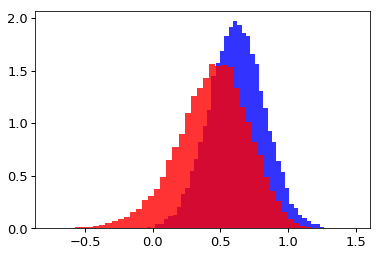

In [203]:
mpeak_mask = (mock['mpeak'] > 1e12) & (mock['mpeak'] < 2e12)
sample = mock[mpeak_mask]

cenmask = sample['scale_factor_mpeak'] > 1
cens = sample[cenmask]
sats = sample[~cenmask]

fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(cens['r50']), bins=50, normed=True, alpha=0.8, color='blue')
__=ax.hist(np.log10(sats['r50']), bins=50, normed=True, alpha=0.8, color='red')


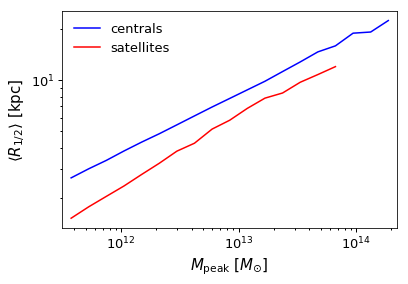

In [238]:
all_cens = mock[mock['upid']==-1]
all_sats = mock[mock['upid']!=-1]
mpeak_bins = np.logspace(11.5, 14.35, 20)
mpeak_mids = 10**(0.5*(np.log10(mpeak_bins[:-1]) + np.log10(mpeak_bins[1:])))

median_size_cens, __, __ = binned_statistic(all_cens['mpeak'], all_cens['r50'], bins=mpeak_bins)
median_size_sats, __, __ = binned_statistic(all_sats['mpeak'], all_sats['r50'], bins=mpeak_bins)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()

xlim = ax.set_xlim(mpeak_bins.min(), mpeak_bins.max())

__=ax.plot(mpeak_mids, median_size_cens, color='blue', label='centrals')
__=ax.plot(mpeak_mids[:-3], median_size_sats[:-3], color='red', label='satellites')
xlabel = ax.set_xlabel(r'$M_{\rm peak}$ $[M_{\odot}]$')
ylabel = ax.set_ylabel(r'$\langle R_{1/2}\rangle$ $[{\rm kpc}]$')
legend = ax.legend()

In [207]:
from halotools.mock_observables import return_xyz_formatted_array, wp

def wp_samples(sample, rp_bins=np.logspace(-1, 1.25, 20), pi_max=20., period=250., 
              size_key='r50'):
    """
    """
    
    pos_all = return_xyz_formatted_array(sample['x'], sample['y'], sample['z'], 
                    velocity=sample['vz'], velocity_distortion_dimension='z', period=period)
    
    pos_small = return_xyz_formatted_array(sample['x'], sample['y'], sample['z'], 
                    velocity=sample['vz'], velocity_distortion_dimension='z', period=period, 
                    mask=(sample[size_key] < sample['r50_median']))
    pos_large = return_xyz_formatted_array(sample['x'], sample['y'], sample['z'], 
                    velocity=sample['vz'], velocity_distortion_dimension='z', period=period, 
                    mask=(sample[size_key] >= sample['r50_median']))
    
    wp_all = wp(pos_all, rp_bins, pi_max, period=period)
    wp_small = wp(pos_small, rp_bins, pi_max, period=period)
    wp_large = wp(pos_large, rp_bins, pi_max, period=period)

    rp_mids = 10**(0.5*(np.log10(rp_bins[:-1]) + np.log10(rp_bins[1:])))
    
    return rp_mids, wp_all, wp_small, wp_large

In [181]:
sample = mock[mock['mstar_mpeak_corrected'] > 10**9.75]
rp_mids, wp_sm9p75_mock, wp_sm9p75_small_mock, wp_sm9p75_large_mock = wp_samples(sample)


In [208]:
sample = mock[mock['mstar_mpeak_corrected'] > 10**9.75]
result = wp_samples(sample, size_key='r50_zpeak0')
rp_mids, wp_sm9p75_mock_zpeak0, wp_sm9p75_small_mock_zpeak0, wp_sm9p75_large_mock_zpeak0 = result


In [183]:
sample = mock[mock['mstar_mpeak_corrected'] > 10**10.25]
rp_mids, wp_sm10p25_mock, wp_sm10p25_small_mock, wp_sm10p25_large_mock = wp_samples(sample)


In [209]:
sample = mock[mock['mstar_mpeak_corrected'] > 10**10.25]
result = wp_samples(sample, size_key='r50_zpeak0')
rp_mids, wp_sm10p25_mock_zpeak0, wp_sm10p25_small_mock_zpeak0, wp_sm10p25_large_mock_zpeak0 = result


In [185]:
sample = mock[mock['mstar_mpeak_corrected'] > 10**10.75]
rp_mids, wp_sm10p75_mock, wp_sm10p75_small_mock, wp_sm10p75_large_mock = wp_samples(sample)

sample = mock[mock['mstar_mpeak_corrected'] > 10**11.25]
rp_mids, wp_sm11p25_mock, wp_sm11p25_small_mock, wp_sm11p25_large_mock = wp_samples(sample)

In [210]:
sample = mock[mock['mstar_mpeak_corrected'] > 10**10.75]
result = wp_samples(sample, size_key='r50_zpeak0')
rp_mids, wp_sm10p75_mock_zpeak0, wp_sm10p75_small_mock_zpeak0, wp_sm10p75_large_mock_zpeak0 = result


In [211]:
sample = mock[mock['mstar_mpeak_corrected'] > 10**11.25]
result = wp_samples(sample, size_key='r50_zpeak0')
rp_mids, wp_sm11p25_mock_zpeak0, wp_sm11p25_small_mock_zpeak0, wp_sm11p25_large_mock_zpeak0 = result


In [212]:
fracdiff_sm9p75_mock = (wp_sm9p75_large_mock-wp_sm9p75_small_mock)/wp_sm9p75_mock
fracdiff_sm10p25_mock = (wp_sm10p25_large_mock-wp_sm10p25_small_mock)/wp_sm10p25_mock
fracdiff_sm10p75_mock = (wp_sm10p75_large_mock-wp_sm10p75_small_mock)/wp_sm10p75_mock
fracdiff_sm11p25_mock = (wp_sm11p25_large_mock-wp_sm11p25_small_mock)/wp_sm11p25_mock

In [213]:
fracdiff_sm9p75_mock_zpeak0 = (wp_sm9p75_large_mock_zpeak0-wp_sm9p75_small_mock_zpeak0)/wp_sm9p75_mock_zpeak0
fracdiff_sm10p25_mock_zpeak0 = (wp_sm10p25_large_mock_zpeak0-wp_sm10p25_small_mock_zpeak0)/wp_sm10p25_mock_zpeak0
fracdiff_sm10p75_mock_zpeak0 = (wp_sm10p75_large_mock_zpeak0-wp_sm10p75_small_mock_zpeak0)/wp_sm10p75_mock_zpeak0
fracdiff_sm11p25_mock_zpeak0 = (wp_sm11p25_large_mock_zpeak0-wp_sm11p25_small_mock_zpeak0)/wp_sm11p25_mock_zpeak0

In [214]:
import os
repo_dirname = "/Users/aphearin/work/repositories/python/galsize_models"
output_subdirname = "galsize_models/measurements/data/two_point_functions"
output_dirname = os.path.join(repo_dirname, output_subdirname)

rp = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_rp.npy'))
wp_sdss_sm9p75_smbell = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_wp.npy'))
wp_sdss_sm9p75_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_small_wp.npy'))
wp_sdss_sm9p75_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_large_wp.npy'))
fracdiff_sm9p75_smbell = (wp_sdss_sm9p75_smbell_large-wp_sdss_sm9p75_smbell_small)/wp_sdss_sm9p75_smbell

wp_sdss_sm10p0_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_wp.npy'))
wp_sdss_sm10p0_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_small_wp.npy'))
wp_sdss_sm10p0_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_large_wp.npy'))
fracdiff_sm10p0_smbell = (wp_sdss_sm10p0_smbell_large-wp_sdss_sm10p0_smbell_small)/wp_sdss_sm10p0_smbell

wp_sdss_sm10p25_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_wp.npy'))
wp_sdss_sm10p25_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_small_wp.npy'))
wp_sdss_sm10p25_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_large_wp.npy'))
fracdiff_sm10p25_smbell = (wp_sdss_sm10p25_smbell_large-wp_sdss_sm10p25_smbell_small)/wp_sdss_sm10p25_smbell

wp_sdss_sm10p5_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_wp.npy'))
wp_sdss_sm10p5_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_small_wp.npy'))
wp_sdss_sm10p5_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_large_wp.npy'))
fracdiff_sm10p5_smbell = (wp_sdss_sm10p5_smbell_large-wp_sdss_sm10p5_smbell_small)/wp_sdss_sm10p5_smbell

wp_sdss_sm10p75_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_wp.npy'))
wp_sdss_sm10p75_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_small_wp.npy'))
wp_sdss_sm10p75_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_large_wp.npy'))
fracdiff_sm10p75_smbell = (wp_sdss_sm10p75_smbell_large-wp_sdss_sm10p75_smbell_small)/wp_sdss_sm10p75_smbell

wp_sdss_sm11_smbell = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_wp.npy'))
wp_sdss_sm11_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_small_wp.npy'))
wp_sdss_sm11_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_large_wp.npy'))
fracdiff_sm11_smbell = (wp_sdss_sm11_smbell_large-wp_sdss_sm11_smbell_small)/wp_sdss_sm11_smbell

wp_sdss_sm11p25_smbell = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_wp.npy'))
wp_sdss_sm11p25_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_small_wp.npy'))
wp_sdss_sm11p25_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_large_wp.npy'))
fracdiff_sm11p25_smbell = (wp_sdss_sm11p25_smbell_large-wp_sdss_sm11p25_smbell_small)/wp_sdss_sm11p25_smbell

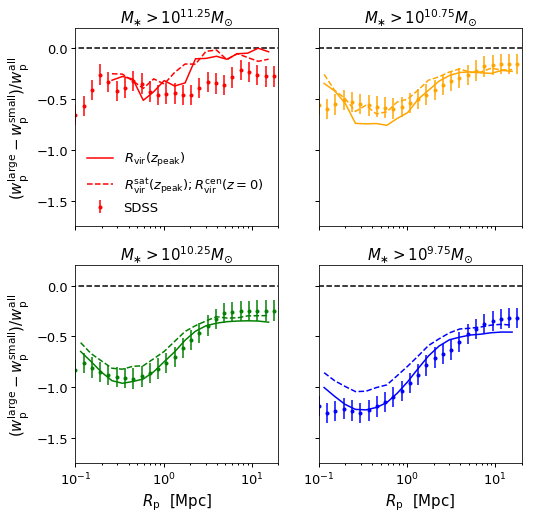

In [216]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                                             figsize=(8, 8))

axes = ax1, ax2, ax3, ax4

for ax in axes:
    ylim = ax.set_ylim(-1.75, 0.2)
    xlim = ax.set_xlim(0.1, 20)
    xscale = ax.set_xscale('log')
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

    
__=ax1.errorbar(rp, fracdiff_sm11p25_smbell, 0.1, fmt='.', color='red', label='SDSS')
__=ax2.errorbar(rp, fracdiff_sm10p75_smbell, 0.1, fmt='.', color='orange')
__=ax3.errorbar(rp, fracdiff_sm10p25_smbell, 0.1, fmt='.', color='green')
__=ax4.errorbar(rp, fracdiff_sm9p75_smbell, 0.1, fmt='.', color='blue')


__=ax1.plot(rp_mids[3:], fracdiff_sm11p25_mock[3:], color='red', 
            label=r'$R_{\rm vir}(z_{\rm peak})$')
__=ax2.plot(rp_mids, fracdiff_sm10p75_mock, color='orange')
__=ax3.plot(rp_mids, fracdiff_sm10p25_mock, color='green')
__=ax4.plot(rp_mids, fracdiff_sm9p75_mock, color='blue')

__=ax1.set_title(r'$M_{\ast} > 10^{11.25}M_{\odot}$')
__=ax2.set_title(r'$M_{\ast} > 10^{10.75}M_{\odot}$')
__=ax3.set_title(r'$M_{\ast} > 10^{10.25}M_{\odot}$')
__=ax4.set_title(r'$M_{\ast} > 10^{9.75}M_{\odot}$')

__=ax1.plot(rp_mids[3:], fracdiff_sm11p25_mock_zpeak0[3:], '--', color='red',
           label=r'$R^{\rm sat}_{\rm vir}(z_{\rm peak}); R^{\rm cen}_{\rm vir}(z=0)$')
__=ax2.plot(rp_mids, fracdiff_sm10p75_mock_zpeak0, '--', color='orange')
__=ax3.plot(rp_mids, fracdiff_sm10p25_mock_zpeak0, '--', color='green')
__=ax4.plot(rp_mids, fracdiff_sm9p75_mock_zpeak0, '--', color='blue')

ylabel1 = ax1.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
ylabel3 = ax3.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
xlabel3 = ax3.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')

leg1 = ax1.legend()

figname = 'size_clustering_ratios_alt_model_vs_sdss.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')
